# 6b. RNA Secondary Structure Analysis

## Pipeline Context

This notebook is **Part 6b** of the gRNA classification pipeline:

1. `2_data_preparation_v3.ipynb` - Data preparation
2. `3_model_training_v3.ipynb` - Model training → **XGBoost selected**
3. `4_model_interpretation_v3.ipynb` - SHAP analysis
4. `5_feature_structure_mapping.ipynb` - Biological feature mapping
5. `6_deep_analysis_v3.ipynb` - Error analysis (Part 6a)
6. **This notebook** - Structure analysis (Part 6b)

## Important Notes

- **LOADS the same trained model** as notebook 3 (XGBoost)
- Uses ViennaRNA for secondary structure prediction
- Analyzes structure of TP, TN, FP, FN sequences

### Caveat

ViennaRNA predicts structure of **isolated RNA molecules**. In reality:
- gRNA functions in **complex with mRNA**
- Anchor region must remain single-stranded for mRNA binding
- Isolated structure prediction may not reflect functional state

---

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import warnings
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Arc
import seaborn as sns
from scipy import stats
import joblib

# ViennaRNA
try:
    import RNA
    VIENNARNA_AVAILABLE = True
    print(f"ViennaRNA version: {RNA.__version__}")
except ImportError:
    VIENNARNA_AVAILABLE = False
    print("WARNING: ViennaRNA not available. Install: pip install ViennaRNA")

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150

RANDOM_STATE = 42
print("Imports complete")

ViennaRNA version: 2.7.1
Imports complete


In [2]:
# =============================================================================
# SETUP PATHS
# =============================================================================

POSSIBLE_BASE_DIRS = [
    Path.home() / 'projects' / 'grna-inspector',
    Path('/mnt/user-data/uploads'),
    Path('.')
]

BASE_DIR = None
for path in POSSIBLE_BASE_DIRS:
    if (path / 'data' / 'processed' / 'v3_pipeline' / 'train_data.csv').exists():
        BASE_DIR = path
        DATA_DIR = path / 'data' / 'processed' / 'v3_pipeline'
        MODELS_DIR = path / 'models'
        break
    elif (path / 'train_data.csv').exists():
        BASE_DIR = path
        DATA_DIR = path
        MODELS_DIR = path
        break

if BASE_DIR is None:
    raise FileNotFoundError("Could not find data files")

OUTPUT_DIR = DATA_DIR / 'deep_analysis'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Data directory: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline
Output directory: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/deep_analysis


In [3]:
# =============================================================================
# LOAD DATA AND MODEL
# =============================================================================

print("="*70)
print("LOADING DATA AND MODEL")
print("="*70)

# Load data
train_df = pd.read_csv(DATA_DIR / 'train_data.csv')
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

# Feature names
feature_file = DATA_DIR / 'feature_names.txt'
if feature_file.exists():
    with open(feature_file) as f:
        feature_names = [l.strip() for l in f if l.strip()]
else:
    exclude = ['sequence_id', 'sequence', 'length', 'label', 'source']
    feature_names = [c for c in train_df.columns if c not in exclude]

print(f"\n✓ Test samples: {len(test_df)}")
print(f"✓ Features: {len(feature_names)}")

HAS_SEQUENCE = 'sequence' in test_df.columns
print(f"✓ Sequences available: {HAS_SEQUENCE}")

# Load model
model_files = list(MODELS_DIR.glob('grna_classifier_*.joblib'))
if model_files:
    model = joblib.load(model_files[0])
    print(f"\n✓ Model loaded: {model_files[0].name}")
else:
    raise FileNotFoundError("Model not found! Run notebook 3 first.")

LOADING DATA AND MODEL

✓ Test samples: 348
✓ Features: 127
✓ Sequences available: True

✓ Model loaded: grna_classifier_xgboost.joblib


In [4]:
# =============================================================================
# GENERATE PREDICTIONS
# =============================================================================

print("="*70)
print("GENERATING PREDICTIONS")
print("="*70)

X_test = test_df[feature_names].values
y_test = test_df['label'].values

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

test_df['predicted'] = y_pred
test_df['probability'] = y_prob

def get_pred_type(row):
    if row['label'] == 1 and row['predicted'] == 1: return 'True Positive'
    elif row['label'] == 0 and row['predicted'] == 0: return 'True Negative'
    elif row['label'] == 0 and row['predicted'] == 1: return 'False Positive'
    else: return 'False Negative'

test_df['prediction_type'] = test_df.apply(get_pred_type, axis=1)

# Verify
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Expected (from notebook 3): TN=161, FP=13, FN=5, TP=169")

if (tn, fp, fn, tp) == (161, 13, 5, 169):
    print("✓ MATCH!")
else:
    print("⚠ MISMATCH - check model file!")

GENERATING PREDICTIONS

Confusion Matrix: TN=161, FP=13, FN=5, TP=169
Expected (from notebook 3): TN=161, FP=13, FN=5, TP=169
✓ MATCH!


In [5]:
# Create subsets
tp_df = test_df[test_df['prediction_type'] == 'True Positive']
tn_df = test_df[test_df['prediction_type'] == 'True Negative']
fp_df = test_df[test_df['prediction_type'] == 'False Positive']
fn_df = test_df[test_df['prediction_type'] == 'False Negative']

print(f"\nSubsets: TP={len(tp_df)}, TN={len(tn_df)}, FP={len(fp_df)}, FN={len(fn_df)}")


Subsets: TP=169, TN=161, FP=13, FN=5


In [6]:
# =============================================================================
# STRUCTURE PREDICTION FUNCTIONS
# =============================================================================

def predict_structure(seq):
    """Predict RNA secondary structure using ViennaRNA."""
    if not VIENNARNA_AVAILABLE or not seq or pd.isna(seq):
        return None
    
    rna_seq = str(seq).upper().replace('T', 'U')
    structure, mfe = RNA.fold(rna_seq)
    
    n_paired = structure.count('(') + structure.count(')')
    
    return {
        'structure': structure,
        'mfe': mfe,
        'mfe_per_nt': mfe / len(seq),
        'paired_fraction': n_paired / len(seq),
        'n_pairs': structure.count('(')
    }

def analyze_anchor(struct):
    """Analyze anchor region (positions 5-15)."""
    if len(struct) < 16:
        anchor = struct[5:] if len(struct) > 5 else ''
    else:
        anchor = struct[5:16]
    
    if not anchor:
        return 0.0, anchor
    return anchor.count('.') / len(anchor), anchor

print("Structure functions defined")

Structure functions defined


In [7]:
# =============================================================================
# PREDICT STRUCTURES
# =============================================================================

if VIENNARNA_AVAILABLE and HAS_SEQUENCE:
    print("="*70)
    print("PREDICTING SECONDARY STRUCTURES")
    print("="*70)
    print(f"\nPredicting structures for {len(test_df)} sequences...")
    
    structures = []
    for idx, row in test_df.iterrows():
        result = predict_structure(row['sequence'])
        if result:
            anchor_open, anchor_struct = analyze_anchor(result['structure'])
            result['anchor_open'] = anchor_open
            result['anchor_struct'] = anchor_struct
            result['prediction_type'] = row['prediction_type']
            result['label'] = row['label']
            result['probability'] = row['probability']
            result['sequence'] = row['sequence']
            result['sequence_id'] = row.get('sequence_id', idx)
            structures.append(result)
    
    struct_df = pd.DataFrame(structures)
    
    # Split by type
    tp_struct = struct_df[struct_df['prediction_type'] == 'True Positive']
    tn_struct = struct_df[struct_df['prediction_type'] == 'True Negative']
    fp_struct = struct_df[struct_df['prediction_type'] == 'False Positive']
    fn_struct = struct_df[struct_df['prediction_type'] == 'False Negative']
    
    print(f"\nStructures predicted:")
    print(f"  True Positives:  {len(tp_struct)}")
    print(f"  True Negatives:  {len(tn_struct)}")
    print(f"  False Positives: {len(fp_struct)}")
    print(f"  False Negatives: {len(fn_struct)}")
else:
    print("Cannot predict structures (ViennaRNA or sequences not available)")

PREDICTING SECONDARY STRUCTURES

Predicting structures for 348 sequences...

Structures predicted:
  True Positives:  169
  True Negatives:  161
  False Positives: 13
  False Negatives: 5


In [8]:
# =============================================================================
# STATISTICAL COMPARISON
# =============================================================================

if VIENNARNA_AVAILABLE and HAS_SEQUENCE:
    print("="*70)
    print("STRUCTURE COMPARISON: gRNA (TP) vs non-gRNA (TN)")
    print("="*70)
    
    metrics = [
        ('mfe', 'MFE (kcal/mol)', 'Lower = more stable'),
        ('mfe_per_nt', 'MFE per nucleotide', 'Lower = more stable'),
        ('paired_fraction', 'Paired fraction', 'Higher = more base pairs'),
        ('anchor_open', 'Anchor openness', 'Higher = better for gRNA function')
    ]
    
    significant_count = 0
    
    for metric, name, note in metrics:
        tp_vals = tp_struct[metric]
        tn_vals = tn_struct[metric]
        
        t_stat, p_val = stats.ttest_ind(tp_vals, tn_vals)
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
        
        if p_val < 0.05:
            significant_count += 1
        
        print(f"\n{name}:")
        print(f"  gRNA (TP):     {tp_vals.mean():.4f} ± {tp_vals.std():.4f}")
        print(f"  non-gRNA (TN): {tn_vals.mean():.4f} ± {tn_vals.std():.4f}")
        print(f"  p-value: {p_val:.4f} {sig}")
        print(f"  ({note})")
        
        if p_val >= 0.05:
            print(f"  ⚠ NOT STATISTICALLY SIGNIFICANT")
        
        # FP comparison
        if len(fp_struct) > 0:
            fp_mean = fp_struct[metric].mean()
            closer = 'gRNA' if abs(fp_mean - tp_vals.mean()) < abs(fp_mean - tn_vals.mean()) else 'non-gRNA'
            print(f"  FP mean: {fp_mean:.4f} → closer to {closer}")
    
    print("\n" + "="*70)
    print(f"SUMMARY: {significant_count}/{len(metrics)} metrics with p < 0.05")
    print("="*70)
    
    if significant_count < len(metrics) // 2:
        print("\n⚠ IMPORTANT: Limited significant structural differences!")
        print("ViennaRNA predicts isolated RNA structure, but gRNA functions")
        print("in complex with mRNA. These results should be interpreted carefully.")

STRUCTURE COMPARISON: gRNA (TP) vs non-gRNA (TN)

MFE (kcal/mol):
  gRNA (TP):     -1.9722 ± 1.7019
  non-gRNA (TN): -2.3702 ± 2.1454
  p-value: 0.0622 ns
  (Lower = more stable)
  ⚠ NOT STATISTICALLY SIGNIFICANT
  FP mean: -2.0154 → closer to gRNA

MFE per nucleotide:
  gRNA (TP):     -0.0473 ± 0.0397
  non-gRNA (TN): -0.0571 ± 0.0504
  p-value: 0.0483 *
  (Lower = more stable)
  FP mean: -0.0490 → closer to gRNA

Paired fraction:
  gRNA (TP):     0.3014 ± 0.1549
  non-gRNA (TN): 0.3282 ± 0.1928
  p-value: 0.1645 ns
  (Higher = more base pairs)
  ⚠ NOT STATISTICALLY SIGNIFICANT
  FP mean: 0.2386 → closer to gRNA

Anchor openness:
  gRNA (TP):     0.6939 ± 0.2483
  non-gRNA (TN): 0.6183 ± 0.2849
  p-value: 0.0105 *
  (Higher = better for gRNA function)
  FP mean: 0.7343 → closer to gRNA

SUMMARY: 2/4 metrics with p < 0.05


In [9]:
# =============================================================================
# FALSE POSITIVE STRUCTURES
# =============================================================================

if VIENNARNA_AVAILABLE and HAS_SEQUENCE and len(fp_struct) > 0:
    print("="*70)
    print("FALSE POSITIVE STRUCTURES")
    print("="*70)
    print("\nDot-bracket notation: . = unpaired, ( ) = paired")
    print("Anchor (pos 5-15) should be OPEN for gRNA function\n")
    
    for i, (_, row) in enumerate(fp_struct.iterrows()):
        print(f"{'─'*60}")
        print(f"FP #{i+1}: MFE={row['mfe']:.1f}, Paired={row['paired_fraction']:.0%}, Prob={row['probability']:.2f}")
        
        seq = row['sequence']
        struct = row['structure']
        print(f"Seq:    {seq[:50]}..." if len(seq) > 50 else f"Seq:    {seq}")
        print(f"Struct: {struct[:50]}..." if len(struct) > 50 else f"Struct: {struct}")
        print(f"Anchor: {row['anchor_struct']} ({row['anchor_open']:.0%} open)")
        
        if row['anchor_open'] > 0.7:
            print("→ ANCHOR IS OPEN (gRNA-like!) - explains error")

FALSE POSITIVE STRUCTURES

Dot-bracket notation: . = unpaired, ( ) = paired
Anchor (pos 5-15) should be OPEN for gRNA function

────────────────────────────────────────────────────────────
FP #1: MFE=0.0, Paired=0%, Prob=0.77
Seq:    TAAATAGAGGTATGTGATAAGTTAGATA
Struct: ............................
Anchor: ........... (100% open)
→ ANCHOR IS OPEN (gRNA-like!) - explains error
────────────────────────────────────────────────────────────
FP #2: MFE=-7.0, Paired=42%, Prob=0.84
Seq:    ATACACAAATACCGTGCTATTTTGTAGGAGGGAAGTGGAATATGTTGT
Struct: ...(((.....((.(.((((...)))).).))..)))...........
Anchor: (.....((.(. (64% open)
────────────────────────────────────────────────────────────
FP #3: MFE=-1.4, Paired=41%, Prob=0.92
Seq:    AATACAGAAAATTTAAGGGTAGATATGATATGATATTGTTGGTGTAATA
Struct: ..((((...(((......(((.......)))......)))..))))...
Anchor: (...(((.... (64% open)
────────────────────────────────────────────────────────────
FP #4: MFE=-1.6, Paired=42%, Prob=0.60
Seq:    AAAATACACATACACAACATA

In [10]:
# =============================================================================
# ARC DIAGRAM VISUALIZATION
# =============================================================================

def plot_arc_diagram(seq, struct, title='', ax=None):
    """Draw arc diagram showing base pairs."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 4))
    
    # Parse base pairs
    pairs = []
    stack = []
    for i, char in enumerate(struct):
        if char == '(':
            stack.append(i)
        elif char == ')' and stack:
            pairs.append((stack.pop(), i))
    
    n = min(55, len(seq))
    
    # Region backgrounds
    ax.axvspan(-0.5, 4.5, alpha=0.15, color='#2ecc71', label='Init (1-5)')
    ax.axvspan(4.5, 15.5, alpha=0.2, color='#e74c3c', label='Anchor (6-16)')
    ax.axvspan(15.5, n-5.5, alpha=0.15, color='#3498db', label='Guide')
    ax.axvspan(n-5.5, n-0.5, alpha=0.15, color='#9b59b6', label='Terminal')
    
    # Nucleotides
    nt_colors = {'A': '#27ae60', 'T': '#e74c3c', 'U': '#e74c3c', 'G': '#f39c12', 'C': '#3498db'}
    rna = seq.upper().replace('T', 'U')
    for i, nt in enumerate(rna[:n]):
        ax.text(i, 0, nt, fontsize=9, ha='center', va='center',
                color=nt_colors.get(nt, 'gray'), fontweight='bold')
    
    # Structure symbols
    for i, s in enumerate(struct[:n]):
        color = '#e74c3c' if s != '.' else '#27ae60'
        ax.text(i, -0.5, s, fontsize=7, ha='center', color=color)
    
    # Arcs
    for i, j in pairs:
        if i < n and j < n:
            in_anchor = (5 <= i < 16) or (5 <= j < 16)
            color = '#e74c3c' if in_anchor else '#9b59b6'
            alpha = 0.8 if in_anchor else 0.5
            lw = 2 if in_anchor else 1
            
            width = j - i
            height = width / 3
            arc = Arc(((i+j)/2, 0.3), width, height, angle=0, theta1=0, theta2=180,
                     color=color, lw=lw, alpha=alpha)
            ax.add_patch(arc)
    
    ax.set_xlim(-1, n+1)
    ax.set_ylim(-1, max(3, max([j-i for i,j in pairs], default=0)/4))
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.axis('off')
    return ax

print("Arc diagram function defined")

Arc diagram function defined


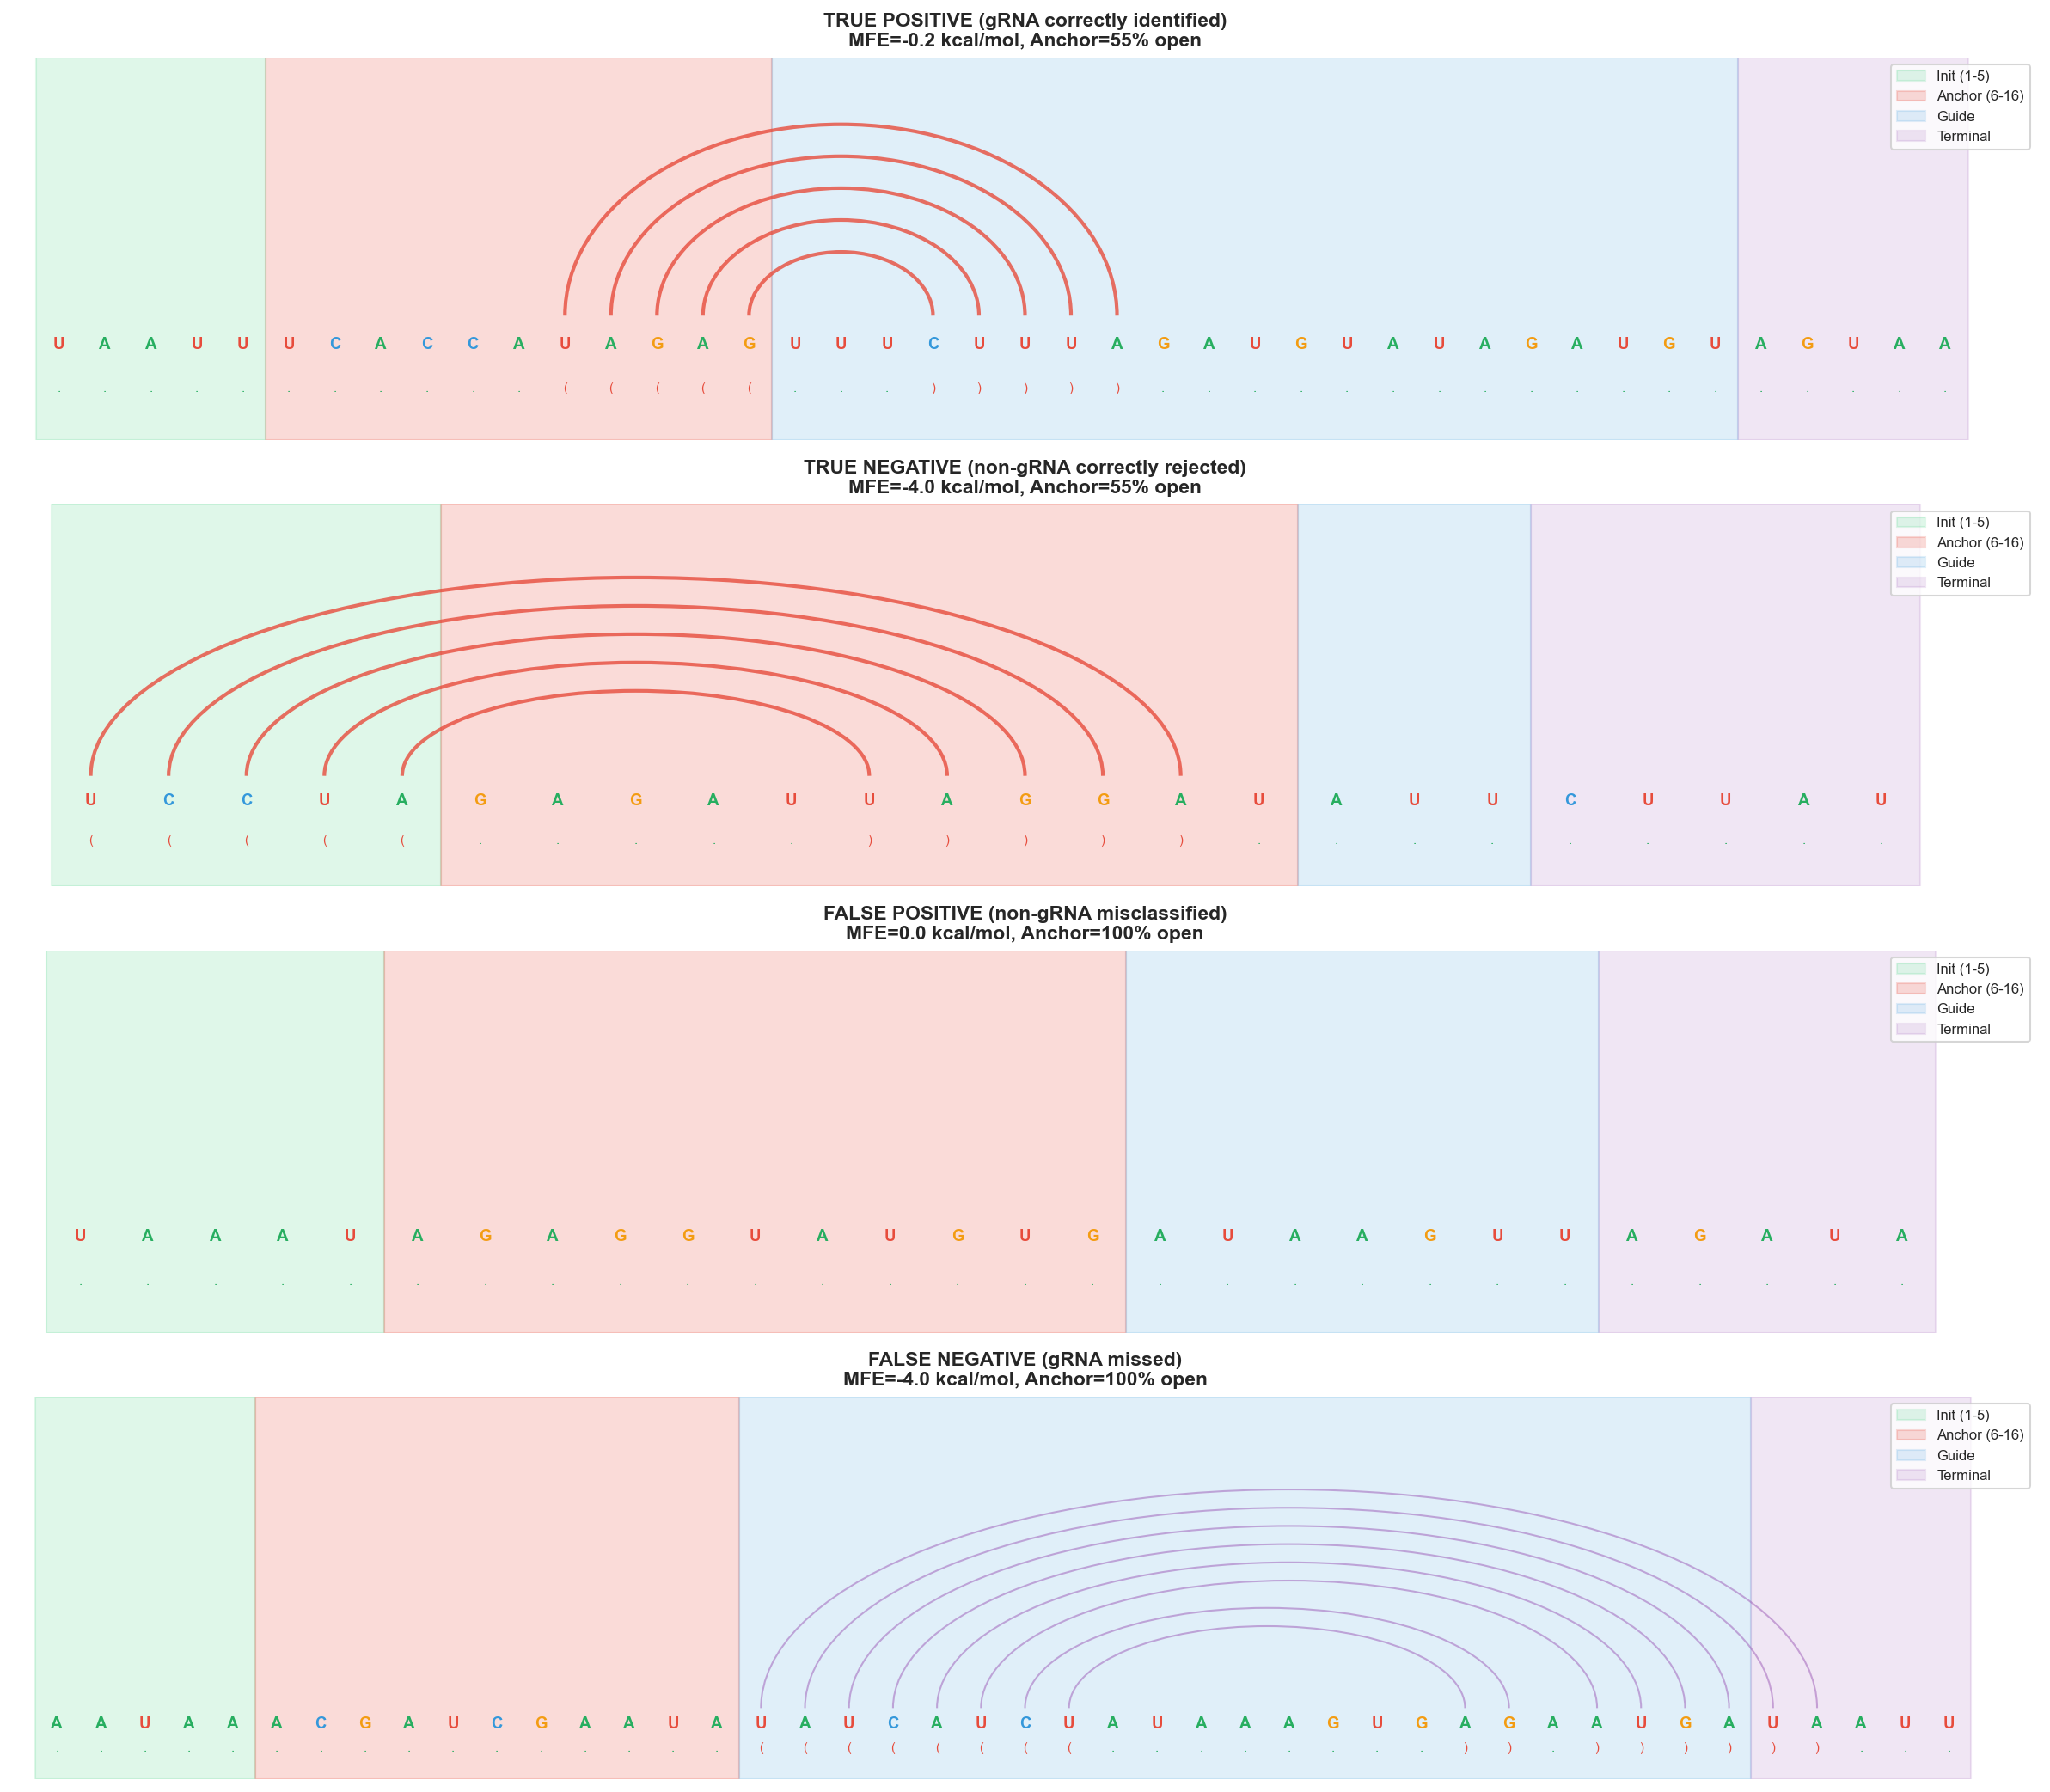

In [14]:
# Compare TP, TN, FP, FN structures
if VIENNARNA_AVAILABLE and HAS_SEQUENCE:
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    
    examples = [
        (tp_struct.iloc[0] if len(tp_struct) > 0 else None, 'TRUE POSITIVE (gRNA correctly identified)', '#27ae60'),
        (tn_struct.iloc[0] if len(tn_struct) > 0 else None, 'TRUE NEGATIVE (non-gRNA correctly rejected)', '#3498db'),
        (fp_struct.iloc[0] if len(fp_struct) > 0 else None, 'FALSE POSITIVE (non-gRNA misclassified)', '#e74c3c'),
        (fn_struct.iloc[0] if len(fn_struct) > 0 else None, 'FALSE NEGATIVE (gRNA missed)', '#f39c12')
    ]
    
    for ax, (example, label, color) in zip(axes, examples):
        if example is not None:
            title = f"{label}\nMFE={example['mfe']:.1f} kcal/mol, Anchor={example['anchor_open']:.0%} open"
            plot_arc_diagram(example['sequence'], example['structure'], title, ax)
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color(color)
                spine.set_linewidth(2)
        else:
            ax.text(0.5, 0.5, f"No {label.split()[0]} examples", ha='center', va='center',
                   transform=ax.transAxes, fontsize=12)
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'structure_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

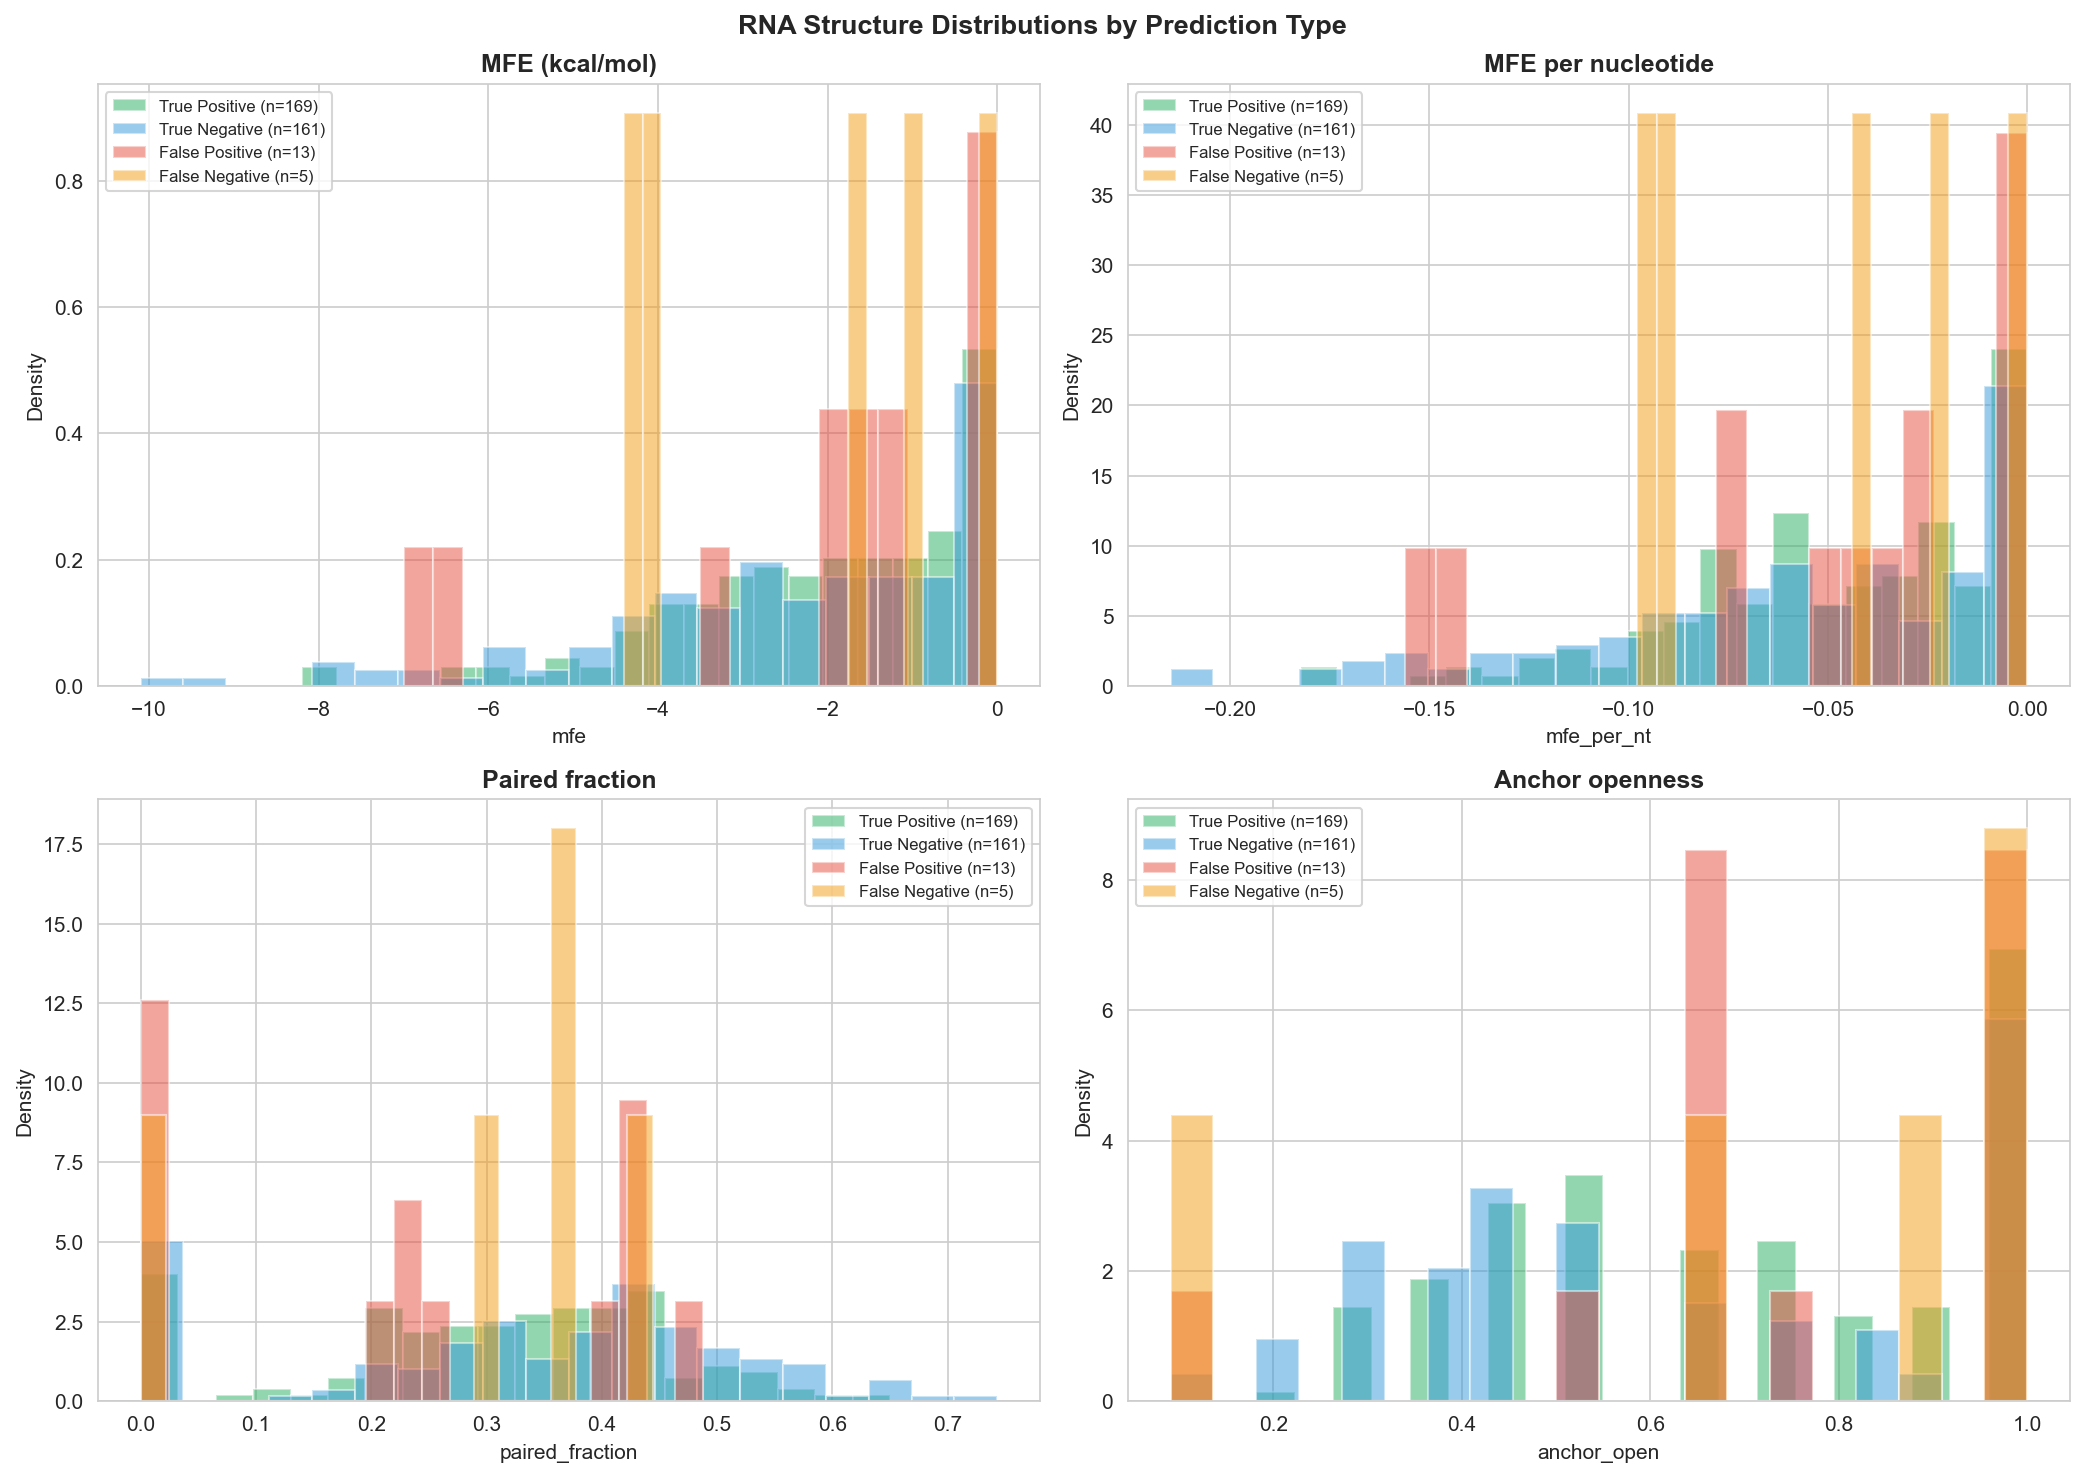

In [15]:
# Distribution plots
if VIENNARNA_AVAILABLE and HAS_SEQUENCE:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = {
        'True Positive': '#27ae60', 'True Negative': '#3498db',
        'False Positive': '#e74c3c', 'False Negative': '#f39c12'
    }
    
    for ax, metric, title in zip(
        axes.flatten(),
        ['mfe', 'mfe_per_nt', 'paired_fraction', 'anchor_open'],
        ['MFE (kcal/mol)', 'MFE per nucleotide', 'Paired fraction', 'Anchor openness']
    ):
        for ptype, color in colors.items():
            subset = struct_df[struct_df['prediction_type'] == ptype][metric]
            if len(subset) > 0:
                ax.hist(subset, bins=20, alpha=0.5, label=f"{ptype} (n={len(subset)})",
                       color=color, density=True)
        ax.set_xlabel(metric)
        ax.set_ylabel('Density')
        ax.set_title(title, fontweight='bold')
        ax.legend(fontsize=8)
    
    plt.suptitle('RNA Structure Distributions by Prediction Type', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'structure_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
# =============================================================================
# BIOLOGICAL CONCLUSIONS
# =============================================================================

if VIENNARNA_AVAILABLE and HAS_SEQUENCE:
    print("="*70)
    print("BIOLOGICAL CONCLUSIONS")
    print("="*70)
    
    tp_mfe = tp_struct['mfe_per_nt'].mean()
    tn_mfe = tn_struct['mfe_per_nt'].mean()
    
    print(f"\n1. THERMODYNAMIC STABILITY:")
    print(f"   gRNA MFE/nt:     {tp_mfe:.3f} kcal/mol/nt")
    print(f"   non-gRNA MFE/nt: {tn_mfe:.3f} kcal/mol/nt")
    if tp_mfe > tn_mfe:
        print(f"   → gRNAs are LESS STABLE (higher MFE)")
        print(f"   → Expected: stable hairpins would prevent mRNA binding")
    
    print(f"\n2. BASE PAIRING:")
    print(f"   gRNA paired:     {tp_struct['paired_fraction'].mean():.1%}")
    print(f"   non-gRNA paired: {tn_struct['paired_fraction'].mean():.1%}")
    
    if 'anchor_open' in tp_struct.columns:
        tp_anchor = tp_struct['anchor_open'].mean()
        tn_anchor = tn_struct['anchor_open'].mean()
        print(f"\n3. ANCHOR REGION (critical for function):")
        print(f"   gRNA anchor openness:     {tp_anchor:.1%}")
        print(f"   non-gRNA anchor openness: {tn_anchor:.1%}")
        if tp_anchor > tn_anchor:
            print(f"   → gRNAs maintain MORE OPEN anchor regions")
    
    if len(fp_struct) > 0:
        fp_anchor = fp_struct['anchor_open'].mean()
        fp_open_count = (fp_struct['anchor_open'] > 0.7).sum()
        print(f"\n4. FALSE POSITIVE EXPLANATION:")
        print(f"   FP anchor openness: {fp_anchor:.1%}")
        print(f"   FP with open anchor (>70%): {fp_open_count}/{len(fp_struct)}")
    
    print("\n" + "="*70)
    print("CAVEATS")
    print("="*70)
    print("""
    1. ViennaRNA predicts ISOLATED RNA structure
    2. gRNA functions in COMPLEX with mRNA - structure may differ
    3. Statistical significance may be limited
    4. Sequence-based features (anchor composition) may be more reliable
    """)

BIOLOGICAL CONCLUSIONS

1. THERMODYNAMIC STABILITY:
   gRNA MFE/nt:     -0.047 kcal/mol/nt
   non-gRNA MFE/nt: -0.057 kcal/mol/nt
   → gRNAs are LESS STABLE (higher MFE)
   → Expected: stable hairpins would prevent mRNA binding

2. BASE PAIRING:
   gRNA paired:     30.1%
   non-gRNA paired: 32.8%

3. ANCHOR REGION (critical for function):
   gRNA anchor openness:     69.4%
   non-gRNA anchor openness: 61.8%
   → gRNAs maintain MORE OPEN anchor regions

4. FALSE POSITIVE EXPLANATION:
   FP anchor openness: 73.4%
   FP with open anchor (>70%): 6/13

CAVEATS

    1. ViennaRNA predicts ISOLATED RNA structure
    2. gRNA functions in COMPLEX with mRNA - structure may differ
    3. Statistical significance may be limited
    4. Sequence-based features (anchor composition) may be more reliable
    


In [17]:
# Save results
if VIENNARNA_AVAILABLE and HAS_SEQUENCE:
    struct_df.to_csv(OUTPUT_DIR / 'rna_structure_analysis.csv', index=False)
    
    print(f"\nResults saved to {OUTPUT_DIR}")
    for f in sorted(OUTPUT_DIR.glob('*')):
        print(f"  {f.name}")


Results saved to /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/deep_analysis
  error_feature_distributions.png
  false_negatives.csv
  false_positives.csv
  feature_comparison_fp_tp_tn.csv
  importance_comparison.csv
  importance_comparison.png
  rna_structure_analysis.csv
  structure_comparison.png
  structure_distributions.png
